In [1]:
import pandas as pd
import numpy as np
import os
from utils import DS_PATH
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

In [2]:
TRACKS_PATH = os.path.join(DS_PATH, 'tracks_filtered_small.csv')
tracks = pd.read_csv(TRACKS_PATH, index_col=0)
tracks.head(10)

,split,genre
track_id,,
2,training,Hip-Hop
5,training,Hip-Hop
10,training,Pop
140,training,Folk
141,training,Folk
148,validation,Experimental
182,test,Rock
190,training,Folk
193,training,Folk


In [3]:
labels = pd.get_dummies(tracks['genre'], prefix='', prefix_sep='').columns
labels_count = len(labels)
labels_count, labels

(8,
 Index(['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental',
        'International', 'Pop', 'Rock'],
       dtype='object'))

In [4]:
del tracks

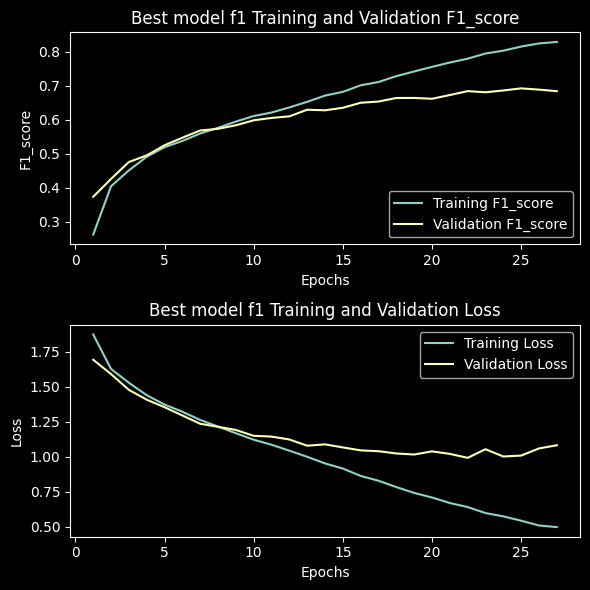

<Figure size 640x480 with 0 Axes>

In [5]:
from utils import draw_training_history, load_model_history

model15_history = load_model_history('model15_f1')
draw_training_history('best model f1', model15_history, 'f1_score')

In [6]:
epochs = 25

In [5]:
SPECTROGRAMS_PATH = os.path.join(os.getcwd(), 'pickled_spectrograms')
SPLIT_DURATION = 3.0

def get_set(
        set_name: str,
        spectrograms_path: str = SPECTROGRAMS_PATH,
        duration: float = SPLIT_DURATION
    ) -> np.ndarray:
    set_file_path = os.path.join(spectrograms_path, f'{set_name}_{duration}s.npz')
    return np.load(set_file_path, mmap_mode='r')

In [6]:
train_set = get_set('train_small')
x_train = train_set['X']
y_train = train_set['y']
del train_set
x_train.shape, y_train.shape

((52676, 128, 130), (52676, 8))

In [7]:
np.unique(y_train.argmax(axis=1))

array([0, 1, 2, 3, 4, 5, 6, 7])

In [8]:
max_value = np.max(x_train)
max_value

42.62

In [9]:
input_shape = x_train[0].shape
input_shape

(128, 130)

In [10]:
from cnn_models import (
    compile_model, evaluate_model, train_model,
    SpectrogramGenerator
)
from utils import create_model_path, draw_confusion_matrix

BATCH_SIZE = 128

In [11]:
val_set = get_set('validation_small')
x_val = val_set['X']
y_val = val_set['y']
del val_set
x_val.shape, y_val.shape

((15125, 128, 130), (15125, 8))

In [12]:
np.unique(y_val.argmax(axis=1))

array([0, 1, 2, 3, 4, 5, 6, 7])

In [13]:
x_train = np.concatenate((x_train, x_val))
y_train = np.concatenate((y_train, y_val))
x_train.shape, y_train.shape

((67801, 128, 130), (67801, 8))

In [14]:
del x_val, y_val

In [15]:
training_data_generator = SpectrogramGenerator(x_train, y_train, batch_size=BATCH_SIZE)

In [16]:
from keras.layers import Input

input = Input((*input_shape, 1))

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Rescaling
from tensorflow_addons.metrics import F1Score

best_model_f1 = Sequential([
        input,
        Rescaling(1 / max_value),

        Conv2D(64, kernel_size=2, strides=1, activation='relu'),
        MaxPooling2D(),

        Conv2D(128, kernel_size=2, strides=1, activation='relu'),
        MaxPooling2D(),

        Conv2D(256, kernel_size=2, strides=1, activation='relu'),
        MaxPooling2D(),
        Dropout(0.5),

        Conv2D(256, kernel_size=2, strides=1, activation='relu'),
        MaxPooling2D(),

        Conv2D(512, kernel_size=2, strides=1, activation='relu'),
        MaxPooling2D(),

        Conv2D(512, kernel_size=2, strides=1, activation='relu'),
        MaxPooling2D(),

        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),

        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(labels_count, activation='softmax'),
    ])

best_model_f1 = compile_model(best_model_f1, F1Score(labels_count, average='micro'))

/mnt/WD-shared/PJATK/PracaMagisterska/kafka-ml/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 130, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 127, 129, 64)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 63, 128)       32896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 256)       1

In [19]:
best_model_f1_path = create_model_path('best_model_f1')

In [20]:
best_model_f1, best_model_f1_history = train_model(
    best_model_f1,
    training_data_generator,
    best_model_f1_path,
    epochs=epochs,
    early_stopping_monitor='loss',
    model_checkpoint_monitor='f1_score',
    reduce_lr_monitor='f1_score',
    reduce_lr_patience=3)

Epoch 1/25
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-07-23 20:07:35.574696: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


529/529 [==============================] - 75s 131ms/step - loss: 1.8067 - f1_score: 0.2923 - lr: 0.0010
Epoch 2/25
529/529 [==============================] - 69s 130ms/step - loss: 1.5596 - f1_score: 0.4342 - lr: 0.0010
Epoch 3/25
529/529 [==============================] - 69s 131ms/step - loss: 1.4061 - f1_score: 0.5068 - lr: 0.0010
Epoch 4/25
529/529 [==============================] - 69s 130ms/step - loss: 1.3131 - f1_score: 0.5421 - lr: 0.0010
Epoch 5/25
529/529 [==============================] - 69s 131ms/step - loss: 1.2425 - f1_score: 0.5704 - lr: 0.0010
Epoch 6/25
529/529 [==============================] - 69s 131ms/step - loss: 1.1873 - f1_score: 0.5878 - lr: 0.0010
Epoch 7/25
529/529 [==============================] - 69s 131ms/step - loss: 1.1371 - f1_score: 0.6064 - lr: 0.0010
Epoch 8/25
529/529 [==============================] - 69s 131ms/step - loss: 1.0945 - f1_score: 0.6215 - lr: 0.0010
Epoch 9/25
529/529 [==============================] - 69s 130ms/step - loss: 1.0574

In [22]:
test_set = get_set('test_small')
x_test = test_set['X']
y_test = test_set['y']
del test_set
x_test.shape, y_test.shape

((7451, 128, 130), (7451, 8))

In [23]:
test_data_generator = SpectrogramGenerator(x_test, y_test, batch_size=BATCH_SIZE, to_fit=True)

In [25]:
evaluate_model(best_model_f1, test_data_generator)

58/58 [==============================] - 2s 24ms/step - loss: 0.9832 - f1_score: 0.6828


{'loss': 0.9832414388656616, 'f1_score': 0.6827855706214905}

In [24]:
pred_data_generator = SpectrogramGenerator(x_test, y_test, batch_size=1, to_fit=False, shuffle=False)

In [25]:
from cnn_models import model_prediction

y_pred = model_prediction(best_model_f1, pred_data_generator, BATCH_SIZE)

NameError: name 'best_model_f1' is not defined

In [26]:
y_test[0].argmax(), y_pred[0].argmax()

NameError: name 'y_pred' is not defined

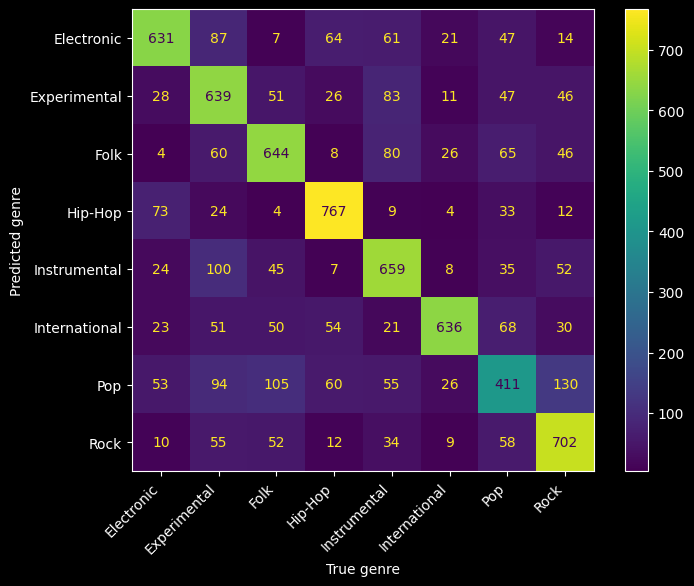

In [29]:
draw_confusion_matrix(y_test, y_pred, labels)

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=labels))

               precision    recall  f1-score   support

   Electronic       0.75      0.68      0.71       932
 Experimental       0.58      0.69      0.63       931
         Folk       0.67      0.69      0.68       933
      Hip-Hop       0.77      0.83      0.80       926
 Instrumental       0.66      0.71      0.68       930
International       0.86      0.68      0.76       933
          Pop       0.54      0.44      0.48       934
         Rock       0.68      0.75      0.71       932

     accuracy                           0.68      7451
    macro avg       0.69      0.68      0.68      7451
 weighted avg       0.69      0.68      0.68      7451



In [29]:
best_model_history = load_model_history('model15')

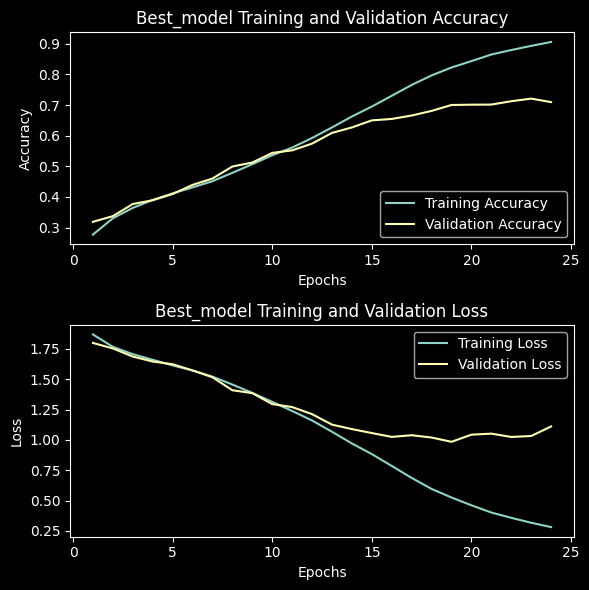

<Figure size 640x480 with 0 Axes>

In [31]:
draw_training_history('best_model', best_model_history)

In [35]:
from keras.layers import AveragePooling2D, GlobalAveragePooling2D

best_model = Sequential([
        input,
        Rescaling(1 / max_value),

        Conv2D(64, kernel_size=2, strides=1, activation='elu'),
        AveragePooling2D(),

        Conv2D(128, kernel_size=2, strides=1, activation='elu'),
        AveragePooling2D(),

        Conv2D(256, kernel_size=2, strides=1, activation='elu'),
        AveragePooling2D(),
        Dropout(0.5),

        Conv2D(256, kernel_size=2, strides=1, activation='elu'),
        AveragePooling2D(),

        Conv2D(512, kernel_size=2, strides=1, activation='elu'),
        AveragePooling2D(),

        Conv2D(512, kernel_size=2, strides=1, activation='elu'),
        GlobalAveragePooling2D(),

        Flatten(),
        Dense(1024, activation='elu'),
        Dropout(0.5),

        Dense(512, activation='elu'),
        Dense(256, activation='elu'),
        Dense(128, activation='elu',),
        Dense(64, activation='elu'),
        Dense(labels_count, activation='softmax'),
    ])

best_model = compile_model(best_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 130, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 127, 129, 64)      320       
                                                                 
 average_pooling2d (AverageP  (None, 63, 64, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 63, 128)       32896     
                                                                 
 average_pooling2d_1 (Averag  (None, 31, 31, 128)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 256)       1

In [36]:
best_model_path = create_model_path('best_model')

In [37]:
epochs = 23

In [38]:
best_model, best_model_history = train_model(
    best_model,
    training_data_generator,
    best_model_path,
    epochs=epochs,
)

Epoch 1/23


2023-07-23 21:28:26.527921: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


529/529 [==============================] - 89s 160ms/step - loss: 1.8490 - accuracy: 0.2881 - lr: 0.0010
Epoch 2/23
529/529 [==============================] - 85s 160ms/step - loss: 1.7369 - accuracy: 0.3481 - lr: 0.0010
Epoch 3/23
529/529 [==============================] - 85s 160ms/step - loss: 1.6779 - accuracy: 0.3795 - lr: 0.0010
Epoch 4/23
529/529 [==============================] - 85s 161ms/step - loss: 1.6247 - accuracy: 0.4061 - lr: 0.0010
Epoch 5/23
529/529 [==============================] - 85s 161ms/step - loss: 1.5646 - accuracy: 0.4334 - lr: 0.0010
Epoch 6/23
529/529 [==============================] - 85s 161ms/step - loss: 1.4851 - accuracy: 0.4670 - lr: 0.0010
Epoch 7/23
529/529 [==============================] - 86s 162ms/step - loss: 1.4064 - accuracy: 0.4970 - lr: 0.0010
Epoch 8/23
529/529 [==============================] - 86s 162ms/step - loss: 1.3237 - accuracy: 0.5307 - lr: 0.0010
Epoch 9/23
529/529 [==============================] - 86s 162ms/step - loss: 1.2373

In [40]:
evaluate_model(best_model, test_data_generator, batch_size=BATCH_SIZE)

58/58 [==============================] - 3s 44ms/step - loss: 0.9225 - accuracy: 0.7496


{'loss': 0.92251056432724, 'accuracy': 0.7495958805084229}

In [42]:
y_pred = model_prediction(best_model, pred_data_generator, 1)

7451/7451 [==============================] - 11s 1ms/step


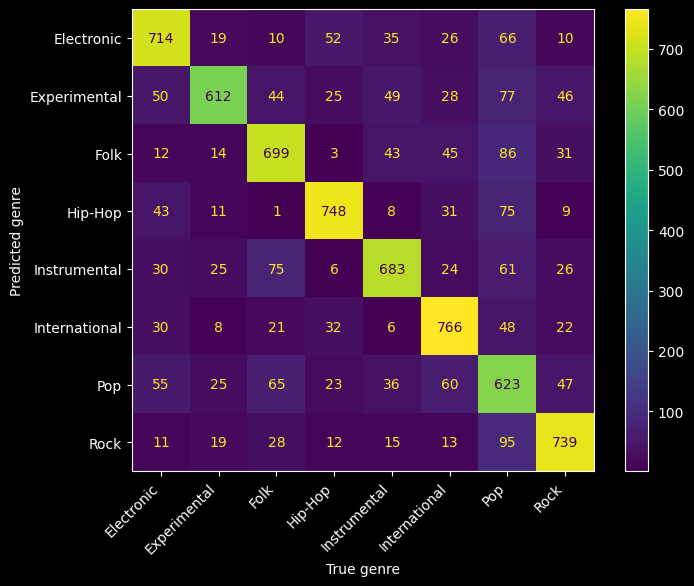

In [43]:
draw_confusion_matrix(y_test, y_pred, labels)

In [47]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=labels))

               precision    recall  f1-score   support

   Electronic       0.76      0.77      0.76       932
 Experimental       0.83      0.66      0.74       931
         Folk       0.74      0.75      0.75       933
      Hip-Hop       0.83      0.81      0.82       926
 Instrumental       0.78      0.73      0.76       930
International       0.77      0.82      0.80       933
          Pop       0.55      0.67      0.60       934
         Rock       0.79      0.79      0.79       932

     accuracy                           0.75      7451
    macro avg       0.76      0.75      0.75      7451
 weighted avg       0.76      0.75      0.75      7451

